### Feature Engineering

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from kerastuner import HyperModel
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'fear-greed']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # Index 3 corresponds to the 'Close' price
    return np.array(x), np.array(y)

file_path = 'dataset.csv'
data, scaler = load_data(file_path)

time_step = 60
x, y = create_dataset(data, time_step)
x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2]))

# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size - time_step:train_size + val_size]
test_data = data[train_size + val_size - time_step:]

x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

<ipython-input-2-8125cbab30fe>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


### LSTM

Trial 20 Complete [00h 00m 37s]
val_loss: 0.0006246217817533761

Best val_loss So Far: 0.0006246217817533761
Total elapsed time: 00h 08m 24s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Mean Squared Error (MSE): 3.4554910527583766
Root Mean Squared Error (RMSE): 1.8588951161263447
Mean Absolute Error (MAE): 1.5159158221991345
R-squared (R²) Score: 0.8896441784919569
Mean Absolute Percentage Error (MAPE): 2.1688382234744195%


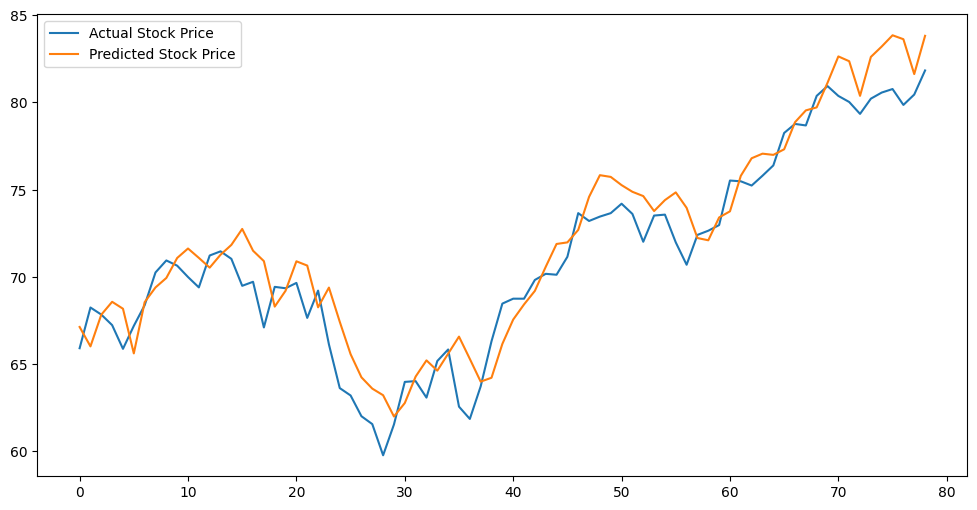

In [3]:
# Define the model for Keras Tuner
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), return_sequences=False))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=16)))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Perform hyperparameter tuning with Keras Tuner
tuner = BayesianOptimization(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='stock_prediction'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
lstm_predictions = best_model.predict(x_test)
lstm_predictions = scaler.inverse_transform(np.concatenate([np.zeros((lstm_predictions.shape[0], data.shape[1]-1)), lstm_predictions], axis=1))[:, -1]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(y_test, lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions)
r2 = r2_score(y_test, lstm_predictions)
mape = mean_absolute_percentage_error(y_test, lstm_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Optional: Visualize predictions and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(lstm_predictions, label='Predicted Stock Price')
plt.legend()
plt.show()

### SVM

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Squared Error (MSE): 3.6430465975913386
Root Mean Squared Error (RMSE): 1.9086766613523984
Mean Absolute Error (MAE): 1.5769230175128495
R-squared (R²) Score: 0.9057162032514786
Mean Absolute Percentage Error (MAPE): 2.199604783852136%


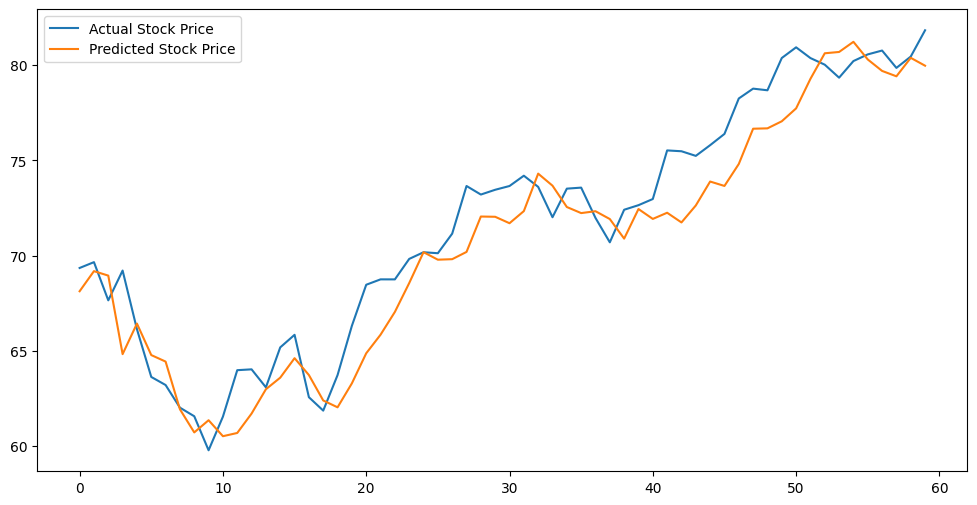

In [4]:
def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # Index 3 corresponds to the 'Close' price
    x = np.array(x)
    y = np.array(y)
    return x.reshape(x.shape[0], -1), y  # Reshape x to 2D for SVM input

file_path = 'dataset.csv'  # Replace with your dataset
data, scaler = load_data(file_path)

time_step = 60  # Number of time steps to look back
x, y = create_dataset(data, time_step)

# Split data into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=train_size, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_size/(test_size + val_size), shuffle=False)

# Define the SVM model with GridSearchCV for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['rbf', 'linear']
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
svm_predictions = best_model.predict(x_test)
svm_predictions = scaler.inverse_transform(np.concatenate([np.zeros((svm_predictions.shape[0], data.shape[1]-1)), svm_predictions.reshape(-1, 1)], axis=1))[:, -1]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data.shape[1]-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate model performance
mse = mean_squared_error(y_test, svm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, svm_predictions)
r2 = r2_score(y_test, svm_predictions)
mape = mean_absolute_percentage_error(y_test, svm_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")

# Optional: Visualize predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(svm_predictions, label='Predicted Stock Price')
plt.legend()
plt.show()

### Unite

Stacking Model - Mean Squared Error (MSE): 2.367241792523941
Stacking Model - Root Mean Squared Error (RMSE): 1.5385843468994285
Stacking Model - Mean Absolute Error (MAE): 1.2823259288722284
Stacking Model - R-squared (R²) Score: 0.938734644742535
Stacking Model - Mean Absolute Percentage Error (MAPE): 1.8143293204245212%


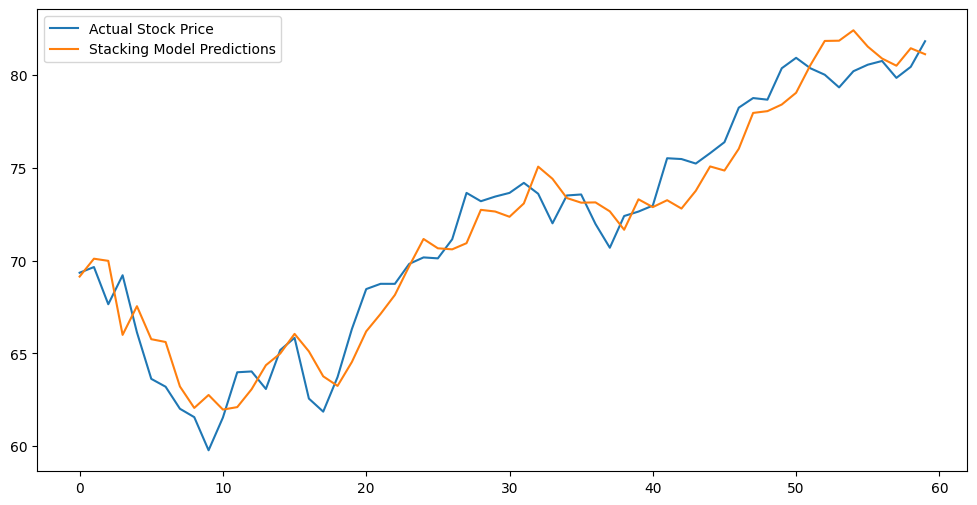

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

min_length = min(len(lstm_predictions), len(svm_predictions))

# Truncate the longer predictions
lstm_predictions = lstm_predictions[:min_length]
svm_predictions = svm_predictions[:min_length]
y_test_truncated = y_test[:min_length]

# Now combine the predictions
stacking_features = np.hstack((lstm_predictions, svm_predictions))

# Train the stacking model
stacking_model = Ridge()
stacking_model.fit(stacking_features, y_test_truncated)

# Make and evaluate predictions
stacking_predictions = stacking_model.predict(stacking_features)

# Evaluate
stacking_mse = mean_squared_error(y_test_truncated, stacking_predictions)
stacking_rmse = np.sqrt(stacking_mse)
stacking_mae = mean_absolute_error(y_test_truncated, stacking_predictions)
stacking_r2 = r2_score(y_test_truncated, stacking_predictions)
stacking_mape = mean_absolute_percentage_error(y_test_truncated, stacking_predictions)

print(f"Stacking Model - Mean Squared Error (MSE): {stacking_mse}")
print(f"Stacking Model - Root Mean Squared Error (RMSE): {stacking_rmse}")
print(f"Stacking Model - Mean Absolute Error (MAE): {stacking_mae}")
print(f"Stacking Model - R-squared (R²) Score: {stacking_r2}")
print(f"Stacking Model - Mean Absolute Percentage Error (MAPE): {stacking_mape * 100}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_truncated, label='Actual Stock Price')
plt.plot(stacking_predictions, label='Stacking Model Predictions')
plt.legend()
plt.show()
